In [1]:
import pandas as pd
import h5py
import numpy as np
import time as tm
%matplotlib inline
import matplotlib.pyplot as plt
import datetime

In [2]:
data_all=pd.read_csv('less_rank_150',sep='\t')
train=data_all[data_all['weeks']!=5]
test=data_all[data_all['weeks']==5]
print(data_all.shape)
print(train.shape)
print(test.shape)
del(data_all)

(104669778, 6)
(88647487, 6)
(16022291, 6)


In [3]:
train=train.loc[:,['artist_id','played_at']]
train['played_at'] = pd.to_datetime(train['played_at'])
train['played_at2']=train['played_at'].apply(lambda t: t.strftime('%Y-%m-%d'))
del(train['played_at'])
train['number']=0
train=train.groupby(['artist_id','played_at2']).count().reset_index()
train.head()

,artist_id,played_at2,number
0,82.0,2016-12-01,93724
1,82.0,2016-12-02,96852
2,82.0,2016-12-03,87826
3,82.0,2016-12-04,90739
4,82.0,2016-12-05,102867


In [4]:
test=test.loc[:,['artist_id','played_at']]
test['played_at'] = pd.to_datetime(test['played_at'])
test['played_at2']=test['played_at'].apply(lambda t: t.strftime('%Y-%m-%d'))
del(test['played_at'])
test['number']=0
test=test.groupby(['artist_id','played_at2']).count().reset_index()
test.tail()

,artist_id,played_at2,number
330,4227444.0,2016-12-26,63460
331,4227444.0,2016-12-27,61229
332,4227444.0,2016-12-28,59893
333,4227444.0,2016-12-29,59731
334,4227444.0,2016-12-30,63474


In [6]:
train['played_at2'] = pd.to_datetime(train['played_at2'])
train.index = train.played_at2
train = train.resample('D').mean()
train.head()

,artist_id,number
played_at2,,
2016-12-01,484532.208955,53452.268657
2016-12-02,484532.208955,54597.298507
2016-12-03,484532.208955,54124.149254
2016-12-04,484532.208955,54615.223881
2016-12-05,484532.208955,51899.910448


In [7]:
test['played_at2'] = pd.to_datetime(test['played_at2'])
test.index = test.played_at2
test = test.resample('D').mean()
test.head()

,artist_id,number
played_at2,,
2016-12-26,484532.208955,48200.671642
2016-12-27,484532.208955,47635.179104
2016-12-28,484532.208955,47260.805970
2016-12-29,484532.208955,47858.641791
2016-12-30,484532.208955,48183.373134


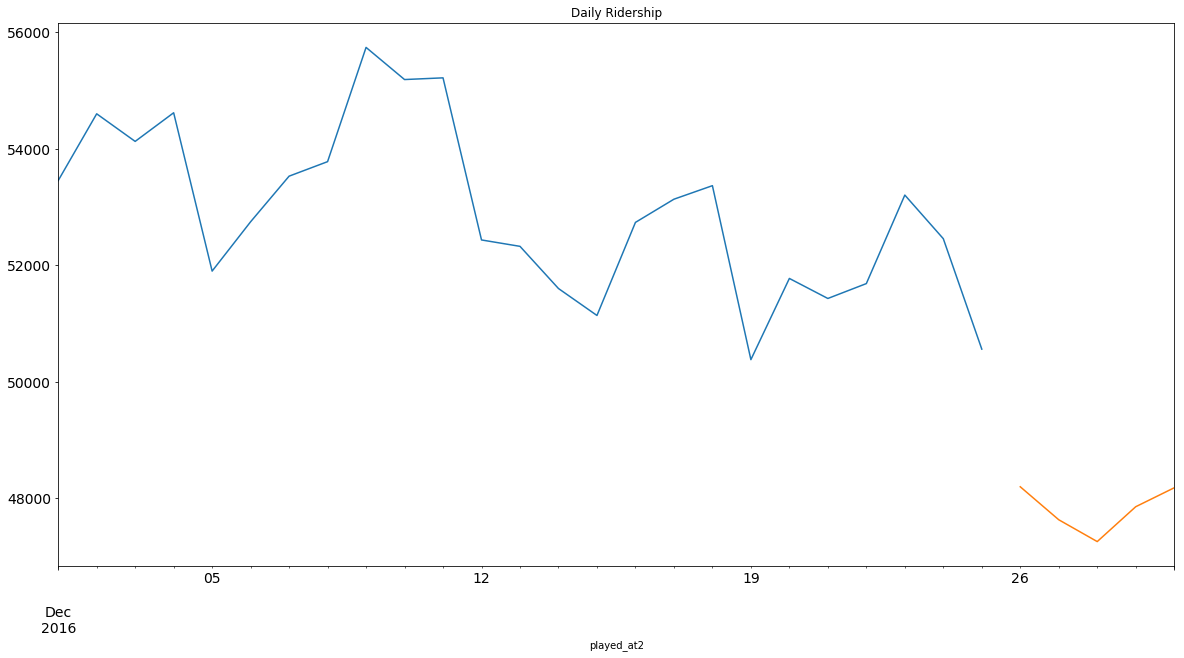

In [8]:
#Plotting data
train.number.plot(figsize=(20,10), title= 'Daily Ridership', fontsize=14)
test.number.plot(figsize=(20,10), title= 'Daily Ridership', fontsize=14)
plt.show()

In [ ]:
#from statsmodels.tsa.api import ExponentialSmoothing

## Method 1: Start with a Naive Approach

In [ ]:
dd= np.asarray(train.number)
y_hat = test.copy()
y_hat['naive'] = dd[len(dd)-1]
plt.figure(figsize=(12,8))
plt.plot(train.index, train['number'], label='Train')
plt.plot(test.index,test['number'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(test.number, y_hat.naive))
print(rms)

#RMSE = 43.9164061439

## Method 2: – Simple Average

In [ ]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['number'].mean()
plt.figure(figsize=(12,8))
plt.plot(train['number'], label='Train')
plt.plot(test['number'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Average Forecast')
plt.legend(loc='best')
plt.show()

In [ ]:
rms = sqrt(mean_squared_error(test.number, y_hat_avg.avg_forecast))
print(rms)

#RMSE = 109.545990803

## Method 3 – Moving Average

In [ ]:
y_hat_avg = test.copy()
y_hat_avg['moving_avg_forecast'] = train['number'].rolling(60).mean().iloc[-1]
plt.figure(figsize=(16,8))
plt.plot(train['number'], label='Train')
plt.plot(test['number'], label='Test')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.show()

In [ ]:
rms = sqrt(mean_squared_error(test.number, y_hat_avg.moving_avg_forecast))
print(rms)
#RMSE = 46.7284072511

## Method 4 – Simple Exponential Smoothing

In [5]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
y_hat_avg = test.copy()
fit2 = SimpleExpSmoothing(np.asarray(train['number'])).fit(smoothing_level=0.6,optimized=False)
y_hat_avg['SES'] = fit2.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot(train['number'], label='Train')
plt.plot(test['number'], label='Test')
plt.plot(y_hat_avg['SES'], label='SES')
plt.legend(loc='best')
plt.show()

/home/e817/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


ImportError: cannot import name 'ExponentialSmoothing'

## Method 5 – Holt’s Linear Trend method

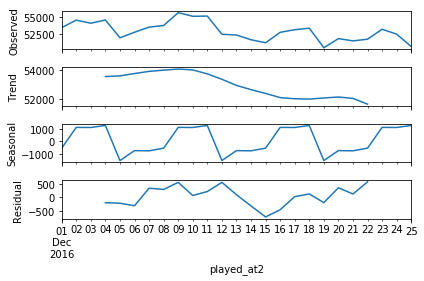

In [9]:
import statsmodels.api as sm
sm.tsa.seasonal_decompose(train.number).plot()
result = sm.tsa.stattools.adfuller(train.number)
plt.show()

In [10]:
y_hat_avg = test.copy()

fit1 = Holt(np.asarray(train['number'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
y_hat_avg['Holt_linear'] = fit1.forecast(len(test))

plt.figure(figsize=(16,8))
plt.plot(train['number'], label='Train')
plt.plot(test['number'], label='Test')
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.show()

NameError: name 'Holt' is not defined